# Hierarchical Model

In [4]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

import arviz as az

from utils.data_utils import destandardize_area, destandardize_price, load_data
from utils.plot_utils import draw_model_plot, set_plot_defaults

In [5]:
set_plot_defaults(font="Europace Sans")
d, zip_lookup, num_zip_codes load_data()

target = "price_s"

## Naive Model

In [6]:
with pm.Model() as hier_model_naiv:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/2.5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/2.5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # sigma also varies by zip code
    sigma = pm.Exponential("sigma", lam=1/2.5, shape=num_zip_codes)
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mu, sd=sigma[d.zip_code.values], observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [06:33<00:00, 20.32draws/s]
There were 448 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6231341310244187, but should be close to 0.8. Try to increase the number of tuning steps.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7005937762039804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 396 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.648914965978378, but should be

In [7]:
bad_model = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"],
                          "sigma": ["zip_code"]})
bad_model

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [8]:
bad_model.to_netcdf("../models/bad_model.nc")

'../models/bad_model.nc'

In [9]:
az.summary(bad_model)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.603,0.058,3.490,3.711,0.002,0.001,808.0,805.0,821.0,1142.0,1.01
mu_beta,2.699,0.090,2.515,2.849,0.004,0.003,641.0,641.0,643.0,1105.0,1.01
alpha[0],4.967,0.164,4.639,5.256,0.005,0.004,1056.0,1056.0,1100.0,395.0,1.01
alpha[1],5.134,0.272,4.558,5.591,0.007,0.005,1482.0,1482.0,1481.0,1360.0,1.00
alpha[2],5.057,0.242,4.628,5.527,0.008,0.005,1014.0,1007.0,1024.0,2318.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
sigma[214],1.915,1.809,0.014,5.068,0.072,0.051,630.0,630.0,490.0,664.0,1.01
sigma[215],0.870,0.934,0.014,2.486,0.037,0.026,644.0,644.0,485.0,895.0,1.01
sigma[216],1.644,1.437,0.023,4.254,0.045,0.032,1039.0,1039.0,734.0,764.0,1.00
sigma[217],1.816,1.760,0.013,5.235,0.157,0.111,126.0,126.0,245.0,106.0,1.02


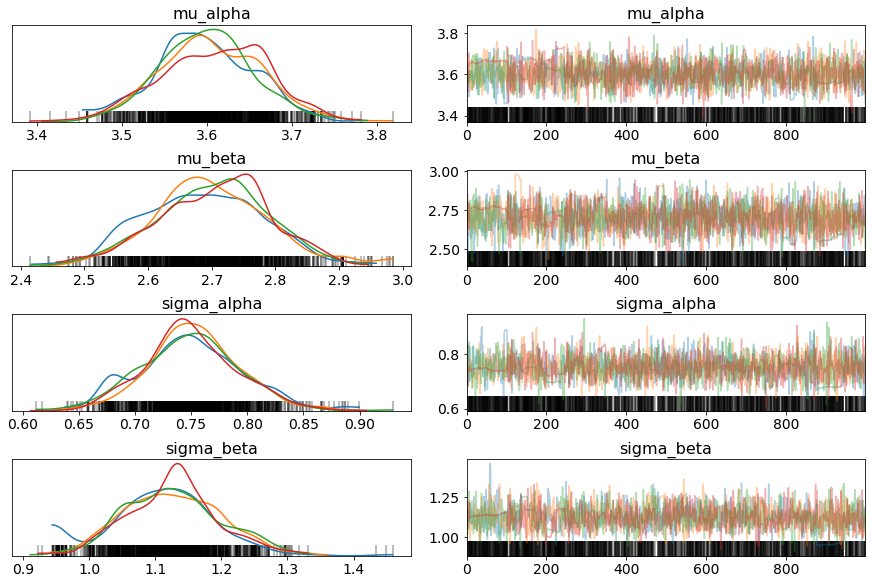

In [10]:
az.plot_trace(bad_model, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta"])
plt.show()

## Centered Parameterization
In some cases, this actually performs better than the non-centered parameterization, see this [discussion](https://discourse.mc-stan.org/t/centered-vs-non-centered-parameterizations/7344)

In [24]:
with pm.Model() as centered_hier_model:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # without varying sigma
    sigma = pm.Exponential("sigma", lam=1/5)
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
100%|██████████| 4000/4000 [00:05<00:00, 715.45it/s]


In [12]:
data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"]})
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19c60d7f28>,
      dtype=object)

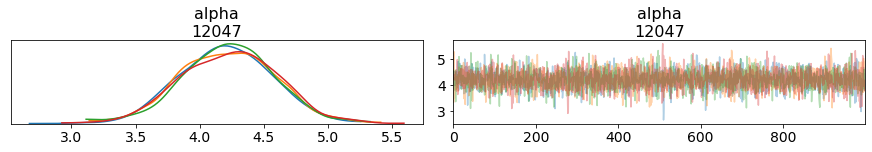

In [13]:
az.plot_trace(data.posterior.where(data.posterior.zip_code.isin(["12047"]), drop=True),
             var_names=["alpha"])

In [14]:
data.to_netcdf("../models/centered_hier.nc")

'../models/centered_hier.nc'

In [15]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.641,0.056,3.534,3.741,0.001,0.001,5877.0,5872.0,5867.0,3246.0,1.0
mu_beta,2.774,0.097,2.593,2.957,0.001,0.001,5797.0,5784.0,5804.0,3104.0,1.0
alpha[0],4.978,0.163,4.671,5.275,0.002,0.001,6398.0,6398.0,6414.0,3328.0,1.0
alpha[1],5.097,0.287,4.564,5.644,0.004,0.003,5885.0,5860.0,5865.0,3322.0,1.0
alpha[2],5.131,0.199,4.768,5.506,0.002,0.002,6460.0,6460.0,6471.0,3174.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[217],2.667,1.292,0.292,5.160,0.014,0.012,8101.0,5462.0,8127.0,2891.0,1.0
beta[218],0.493,0.794,-1.043,1.890,0.010,0.011,6097.0,2854.0,6089.0,3546.0,1.0
sigma_alpha,0.739,0.043,0.657,0.821,0.001,0.000,4525.0,4519.0,4516.0,3116.0,1.0
sigma_beta,1.273,0.073,1.142,1.413,0.001,0.001,4252.0,4240.0,4245.0,2588.0,1.0


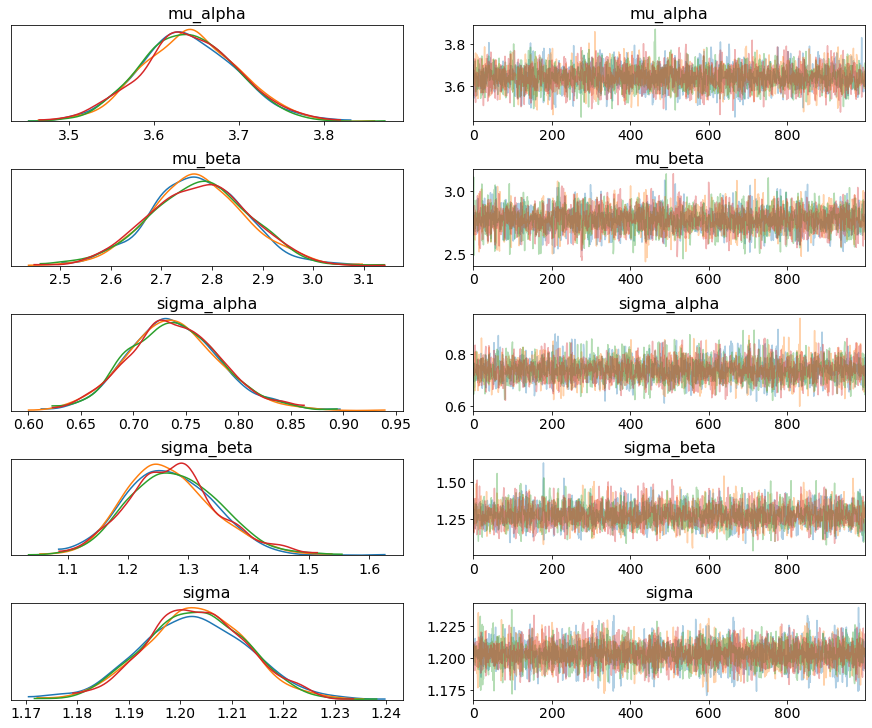

In [16]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Non-Centered Version
See [Blog post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki

In [17]:
with pm.Model() as non_centered_hier:
    
    beta_offset = pm.Normal("beta_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", 1/5)
    beta = mu_beta + beta_offset*sigma_beta
    
    alpha_offset = pm.Normal("alpha_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", 1/5)
    alpha = mu_alpha + alpha_offset*sigma_alpha
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, sigma_alpha, mu_alpha, alpha_offset, sigma_beta, mu_beta, beta_offset]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:09<00:00, 61.84draws/s] 
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 4000/4000 [00:07<00:00, 567.93it/s]


In [18]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_offset[0],0.728,0.255,0.253,1.210,0.005,0.003,3002.0,3002.0,3034.0,3393.0,1.00
beta_offset[1],0.859,0.458,0.021,1.729,0.006,0.005,5659.0,4721.0,5683.0,2775.0,1.00
beta_offset[2],1.299,0.314,0.685,1.848,0.004,0.003,5039.0,4444.0,5059.0,2614.0,1.00
beta_offset[3],-0.191,0.974,-2.100,1.603,0.009,0.018,11560.0,1464.0,11468.0,2664.0,1.00
beta_offset[4],-0.078,0.982,-1.833,1.795,0.010,0.017,9256.0,1604.0,9275.0,2977.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
alpha_offset[218],-0.712,0.943,-2.491,1.063,0.011,0.011,7782.0,3507.0,7774.0,3113.0,1.00
mu_alpha,3.641,0.058,3.535,3.753,0.002,0.002,614.0,614.0,612.0,1224.0,1.01
sigma_beta,1.275,0.071,1.150,1.413,0.003,0.002,591.0,591.0,582.0,1351.0,1.01
sigma_alpha,0.742,0.043,0.660,0.821,0.001,0.001,1079.0,1079.0,1081.0,1793.0,1.01


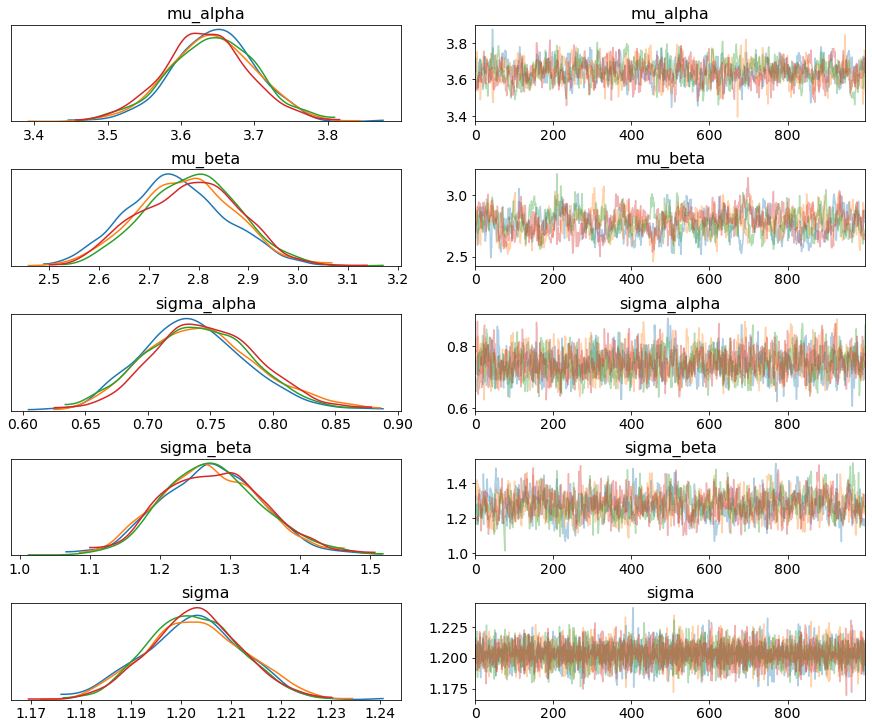

In [19]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Multivariate Model (includes correlation)

In [10]:
with pm.Model() as correlation_hier_model:
    # mu is mean vector for alpha and beta parameter
    mu = pm.Normal("mu", mu=0, sd=5, shape=(2,)) 
    # sigma is scale vector for alpha and beta parameter
    sigma = pm.Exponential("sigma", 1/5, shape=(2,))
    
    C_triu = pm.LKJCorr("C_triu", n=2, p=2)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)
    # scale vector becomes diagonal of covariance matrix
    sigma_diag = tt.nlinalg.diag(sigma)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    tau = tt.nlinalg.matrix_inverse(cov)
    
    # alpha and beta come from a multivariate normal
    # with mean vector mu
    # and covariance matrix tau 
    # tau includes scale for alpha and beta on the diagonals
    # and the correlation on  between alpha and beta off the diagonals
    ab = pm.MvNormal("ab", mu=mu, tau=tau, shape=(num_zip_codes, 2))
    
    sd_price = pm.Exponential("sd_price", lam=1/5)
    
    # compute estimate for price
    mean_price = ab[:,0][d.zip_code.values] + ab[:,1][d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mean_price, sd=sd_price, observed=d[target])
    
    #prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarn

KeyboardInterrupt: 

In [21]:
mvn_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes, 'param': ["alpha", "beta"],
                            "sigma_dim_0": ["alpha", "beta"]},
                     dims={"ab": ["zip_code", "param"],
                          "mu": ["param"]})
mvn_data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [22]:
mvn_data.to_netcdf("../models/mvn_hier.nc")

'../models/mvn_hier.nc'

In [23]:
az.summary(mvn_data)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],3.644,0.059,3.536,3.760,0.001,0.001,2606.0,2606.0,2611.0,2554.0,1.0
mu[1],2.756,0.100,2.556,2.938,0.002,0.001,2777.0,2777.0,2782.0,2769.0,1.0
"ab[0,0]",4.998,0.163,4.692,5.310,0.002,0.002,4450.0,4444.0,4456.0,2811.0,1.0
"ab[0,1]",3.822,0.306,3.261,4.403,0.004,0.003,4858.0,4783.0,4832.0,3083.0,1.0
"ab[1,0]",5.211,0.296,4.654,5.768,0.005,0.003,4010.0,4010.0,4018.0,3041.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"ab[218,1]",0.606,0.615,-0.476,1.815,0.008,0.007,5693.0,3452.0,5689.0,3226.0,1.0
sigma[0],0.767,0.045,0.680,0.850,0.001,0.001,2069.0,2069.0,2071.0,2666.0,1.0
sigma[1],1.291,0.074,1.152,1.431,0.001,0.001,2581.0,2581.0,2562.0,2809.0,1.0
C_triu[0],0.715,0.045,0.628,0.795,0.001,0.001,1571.0,1568.0,1576.0,2760.0,1.0
